In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

df = pd.read_csv('data/processed/merged/merged_dataset.04.csv')

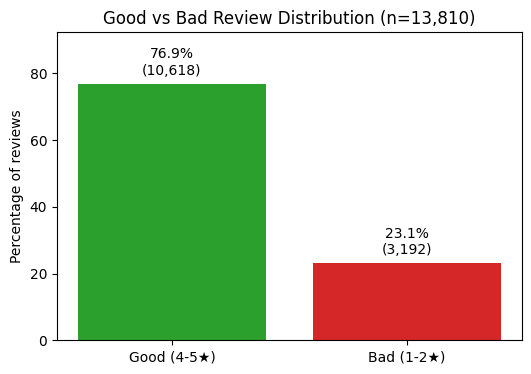

In [2]:
GOOD_BAD_COUNTS = {
    'Good (4-5★)': int(df['rating'].isin([4, 5]).sum()),
    'Bad (1-2★)': int(df['rating'].isin([1, 2]).sum()),
}
counts = pd.Series(GOOD_BAD_COUNTS)
total = counts.sum()
if total == 0:
    print('No labeled reviews (ratings 1/2/4/5) available for plotting.')
else:
    percentages = (counts / total) * 100
    fig, ax = plt.subplots(figsize=(6, 4))
    colors = ['#2ca02c', '#d62728']
    bars = ax.bar(percentages.index, percentages.values, color=colors[: len(percentages)])
    ax.set_ylabel('Percentage of reviews')
    ax.set_title(f'Good vs Bad Review Distribution (n={total:,})')
    ylim_top = max(percentages.max() * 1.2, 15)
    ax.set_ylim(0, ylim_top)
    for bar, label in zip(bars, percentages.index, strict=True):
        pct = percentages[label]
        count = counts[label]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + ylim_top * 0.02,
            f'{pct:.1f}%\n({count:,})',
            ha='center',
            va='bottom',
        )
    plt.show()

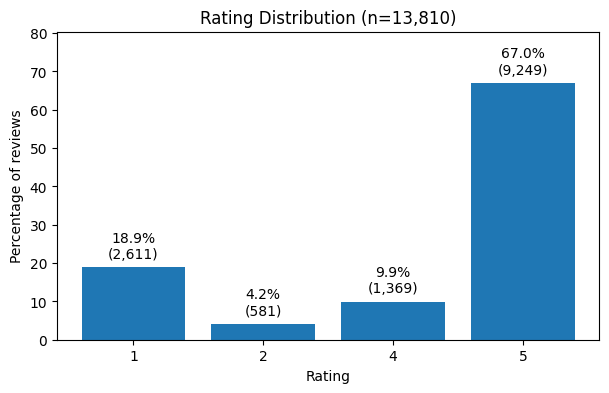

In [3]:
filtered = df[df['rating'].isin([1, 2, 4, 5])]
counts = filtered['rating'].value_counts().reindex([1, 2, 4, 5], fill_value=0)
total = counts.sum()
if total == 0:
    print('No ratings 1, 2, 4, or 5 available for plotting.')
else:
    percentages = (counts / total) * 100
    fig, ax = plt.subplots(figsize=(7, 4))
    bars = ax.bar(counts.index.astype(str), percentages.values, color='#1f77b4')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Percentage of reviews')
    ax.set_title(f'Rating Distribution (n={total:,})')
    ylim_top = max(percentages.max() * 1.2, 15)
    ax.set_ylim(0, ylim_top)
    for bar, rating in zip(bars, counts.index, strict=True):
        pct = percentages.loc[rating]
        count = counts.loc[rating]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + ylim_top * 0.02,
            f'{pct:.1f}%\n({int(count):,})',
            ha='center',
            va='bottom',
        )
    plt.show()

As seen above, the crafted dataset has a very high class imbalance, with an 80%/20% distribution. To evaluate our sentiment classifier, we will use metrics which address this problem: 
- Macro-F1 - insensitive to class imbalances. This metric gives equal weight to the negative and positive classes. Computing the arithmetic mean of the F1 scores calculated independently for each class
- F1 Scores computed for each class - Shows on which class the model performs poorly.
- PR-AUC focuses on true positives, false positives and false negatives, ignoring true negatives. This captures how well the model can retrieve bad reviews accross different thresholds, helping us understand the trade-off between precision and recall for the minority class. 

These metrics will be computed for our majority class baseline. This dummy/baseline model, will then be compared with our trained model.

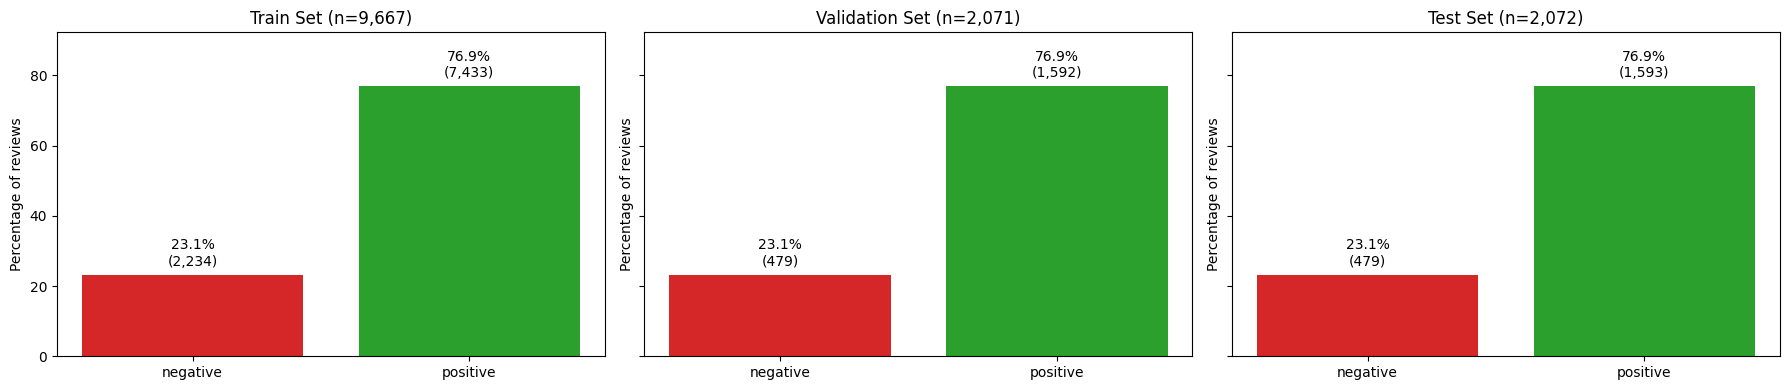

In [4]:
import matplotlib.pyplot as plt

train_path = Path('data/processed/splits/train/train.csv')
val_path = Path('data/processed/splits/val/val.csv')
test_path = Path('data/processed/splits/test/test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)


def plot_class_distribution(ax, data, column, title, palette=None):
    palette = palette or ['#d62728', '#2ca02c']
    counts = data[column].value_counts().sort_index()
    total = counts.sum()
    if total == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_axis_off()
        return
    percentages = (counts / total) * 100
    bars = ax.bar(counts.index.astype(str), percentages.values, color=palette[: len(counts)])
    ax.set_ylabel('Percentage of reviews')
    ax.set_title(f'{title} (n={total:,})')
    ylim_top = max(percentages.max() * 1.2, 15)
    ax.set_ylim(0, ylim_top)
    for bar, pct, count in zip(bars, percentages.values, counts.values, strict=True):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + ylim_top * 0.02,
            f'{pct:.1f}%\n({int(count):,})',
            ha='center',
            va='bottom',
        )


fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
plot_class_distribution(axes[0], df_train, 'sentiment', 'Train Set')
plot_class_distribution(axes[1], df_val, 'sentiment', 'Validation Set')
plot_class_distribution(axes[2], df_test, 'sentiment', 'Test Set')
plt.tight_layout()
plt.show()

We create a dummy classifier to stablish a **majority class baseline** and a **random baseline**, which we will use to compare with respect to our linear models. 

In [5]:
# ruff: noqa: I001
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    average_precision_score,
)

X_train, y_train = df_train['comment'], df_train['sentiment']

maj_clf = DummyClassifier(strategy='most_frequent', random_state=42)
maj_clf.fit(X_train, y_train)

X_val, y_val = df_val['comment'], df_val['sentiment']

y_val_pred = maj_clf.predict(X_val)
maj_proba = maj_clf.predict_proba(X_val)
bad_index = np.where(maj_clf.classes_ == 'negative')[0][0]
bad_scores = maj_proba[:, bad_index]
pr_auc_bad = average_precision_score((y_val == 'negative').astype(int), bad_scores)

**Majority Class Baseline Classifier:**

In [6]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       479
    positive       0.77      1.00      0.87      1592

    accuracy                           0.77      2071
   macro avg       0.38      0.50      0.43      2071
weighted avg       0.59      0.77      0.67      2071



d:\Javier 2.0\Machine Learning\Gym Sentiment Guard\gym-sentiment-guard\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Javier 2.0\Machine Learning\Gym Sentiment Guard\gym-sentiment-guard\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Javier 2.0\Machine Learning\Gym Sentiment Guard\gym-sentiment-guard\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `

As observed, the majority class baseline only predicts the majority class (positive), which produces high values for precision and recall in the positive class, but 0 values for the negative class. Macro F1 average shows that the model is very poor, with a 0.44 score. Weighted average does not give too much weight to the imbalanced class, so it won't be used in our final metrics. 
Metrics:

- F1 score for negative class: 0.0
- Macro-F1: 0.44
- PR-AUC: not significant (0 predicted bad reviews)

**Random Baseline Classifier:**

In [7]:
rand_clf = DummyClassifier(strategy='stratified', random_state=42)
rand_clf.fit(X_train, y_train)

y_val_pred_rand = rand_clf.predict(X_val)
y_val_proba_rand = rand_clf.predict_proba(X_val)  # class-order is rand_clf.classes_

In [8]:
print('Random baseline - classification report (val):')
print(classification_report(y_val, y_val_pred_rand))

# Suppose 'bad' is the second class:
bad_index = np.where(rand_clf.classes_ == 'negative')[0][0]
bad_scores = y_val_proba_rand[:, bad_index]

pr_auc_bad = average_precision_score((y_val == 'negative').astype(int), bad_scores)
print(f'Random baseline PR-AUC (bad class, val): {pr_auc_bad:.3f}')

Random baseline - classification report (val):
              precision    recall  f1-score   support

    negative       0.21      0.21      0.21       479
    positive       0.76      0.76      0.76      1592

    accuracy                           0.63      2071
   macro avg       0.48      0.48      0.48      2071
weighted avg       0.63      0.63      0.63      2071

Random baseline PR-AUC (bad class, val): 0.226


With this model, F1 score has a higher value because the dummy model follows a probability based prediction, predicting 22% of bad reviews and 79% of good reviews. Still, the score is very low, as macro-F1 and PR-AUC follow.

- F1 score for negative class: 0.21
- Macro-F1: 0.48
- PR-AUC: 0.226

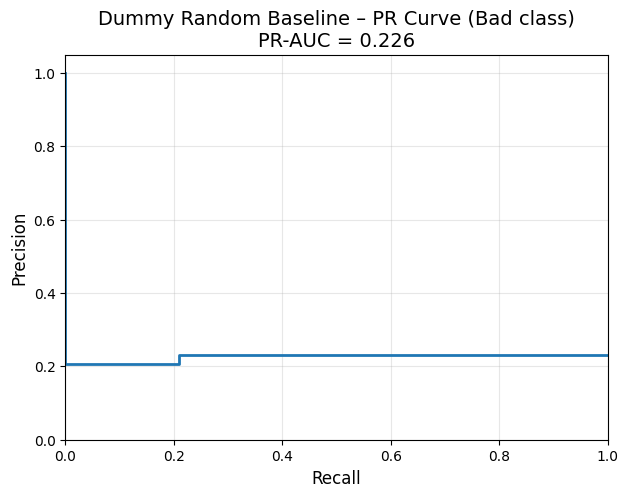

In [9]:
# True binary labels
y_true = (y_val == 'negative').astype(int)

# Probability scores from DummyClassifier
# stratified → predict_proba returns probabilities that match train distribution
proba = rand_clf.predict_proba(X_val)

# We need the probability for the "bad" class
bad_index = np.where(rand_clf.classes_ == 'negative')[0][0]
scores = proba[:, bad_index]

# Compute PR curve
precision, recall, thresholds = precision_recall_curve(y_true, scores)
pr_auc = average_precision_score(y_true, scores)

# Plot
plt.figure(figsize=(7, 5))
plt.step(recall, precision, where='post', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title(f'Dummy Random Baseline – PR Curve (Bad class)\nPR-AUC = {pr_auc:.3f}', fontsize=14)
plt.ylim([0, 1.05])
plt.xlim([0, 1])
plt.grid(alpha=0.3)
plt.show()

Dummy Random Baseline model Precision-Recall Curve shows that precision is constant for the bad class, making it clear that the random model has no ability to classify or rank so it collapses the line into a constant.

### **Document Frequency Distribution**

Now, to calculate a good max document frequency distribution parameter we need to analyze the document frequency of each term. 
```max_df``` is used to control how frequent a term can be before dropping it out from the vocabulary. Terms which appear in a very high percentage of reviews (>90%) won't help the classifier differentiate positive reviews from negative ones. Dropping them will remove vocabulary size, remove noise, speed up training and remove generalization.  

Let's analyze the frequency distribution of the training dataset:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

df_train = pd.read_csv('data/processed/splits/train/train.csv')

X_train = df_train['comment']
y_train = df_train['sentiment']

vectorizer = CountVectorizer()  # simple, no ngrams, just for analysis
X_counts = vectorizer.fit_transform(X_train)

N_docs = X_counts.shape[0]
df_counts = np.asarray((X_counts > 0).sum(axis=0)).ravel()  # df for each term

df_frac = df_counts / N_docs

terms = np.array(vectorizer.get_feature_names_out())
order = np.argsort(df_frac)[::-1]  # from most frequent to least
terms_sorted = terms[order]
df_frac_sorted = df_frac[order]

for term, frac in zip(terms_sorted[:100], df_frac_sorted[:100], strict=True):
    print(f'{term:20s} {frac:.3f}')

de                   0.565
el                   0.442
muy                  0.434
que                  0.398
la                   0.397
en                   0.355
es                   0.310
gimnasio             0.305
con                  0.296
las                  0.292
un                   0.290
los                  0.256
no                   0.254
me                   0.253
por                  0.241
para                 0.234
lo                   0.219
una                  0.202
todo                 0.187
se                   0.185
instalaciones        0.151
bien                 0.151
del                  0.142
pero                 0.136
al                   0.134
buen                 0.131
máquinas             0.131
atención             0.129
clases               0.127
más                  0.124
personal             0.124
son                  0.120
hay                  0.119
gym                  0.114
está                 0.112
este                 0.106
te                   0.104
s

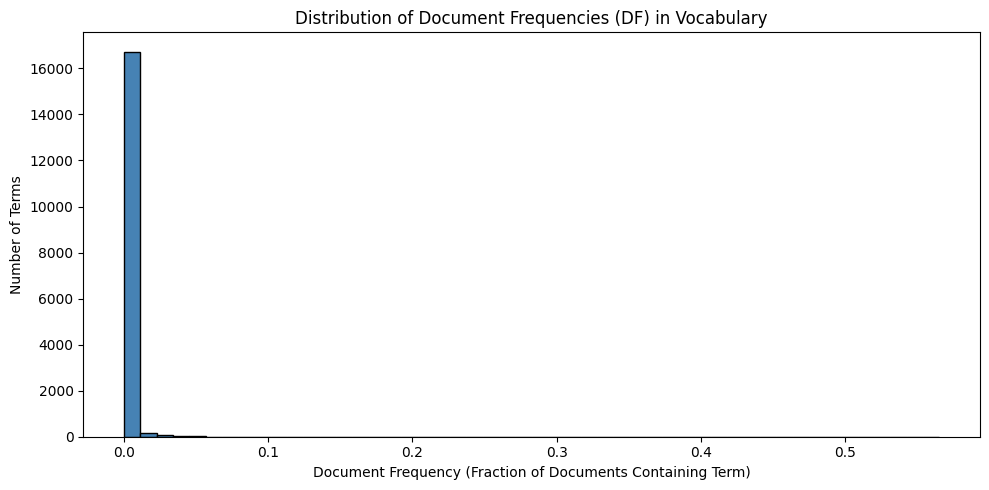

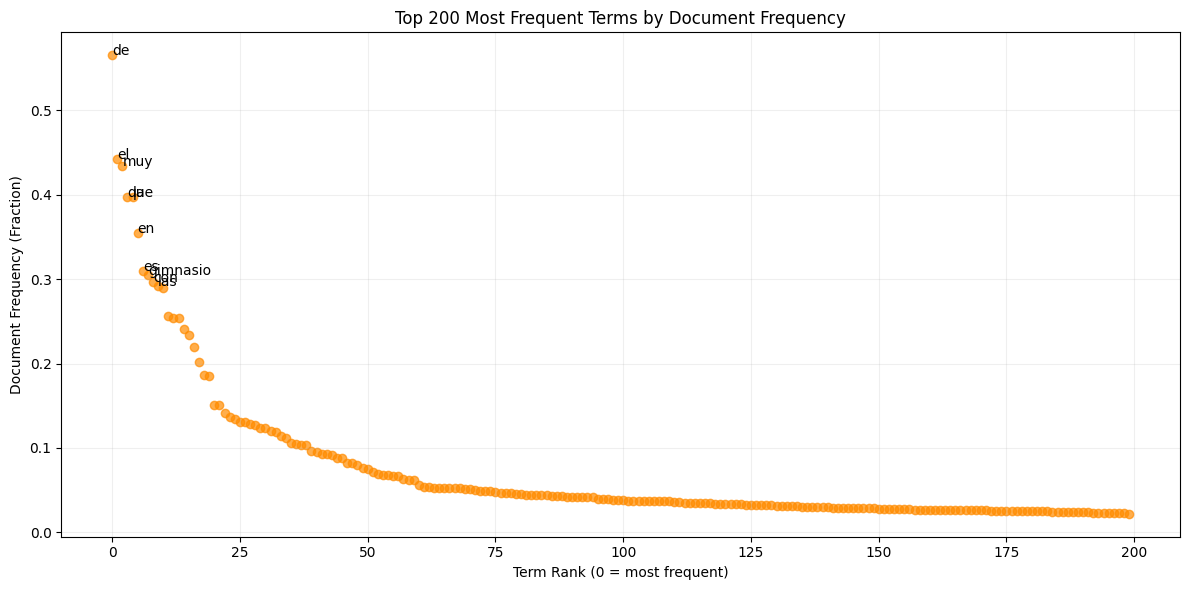

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(df_frac, bins=50, color='steelblue', edgecolor='black')
plt.xlabel('Document Frequency (Fraction of Documents Containing Term)')
plt.ylabel('Number of Terms')
plt.title('Distribution of Document Frequencies (DF) in Vocabulary')
plt.tight_layout()
plt.show()

# Choose top N most frequent terms for visualization
N = 200
top_terms = terms_sorted[:N]
top_df_vals = df_frac_sorted[:N]

plt.figure(figsize=(12, 6))
plt.scatter(range(N), top_df_vals, alpha=0.7, color='darkorange')
plt.title(f'Top {N} Most Frequent Terms by Document Frequency')
plt.ylabel('Document Frequency (Fraction)')
plt.xlabel('Term Rank (0 = most frequent)')
plt.grid(alpha=0.2)

# Annotate a few terms
for i in range(min(10, N)):  # annotate only top 10
    plt.annotate(top_terms[i], (i, top_df_vals[i]))

plt.tight_layout()
plt.show()

With these 2 plots, it is clear that no extremely frequent characters are presented in the reviews. "de", "el" and "muy" are the most frequent, averaging 50% of frequency. Taking into account that TF-IDF does give smaller weights to very high frequent words, there is no need for stopwords removal. For non linear classifiers, this would be essential, but for a first lineal model we will not do it. 

Given that there is no ultra frequent words, TF-IDF already downweights frequent words and that we desire keeping context, default value for ```max_df=1.0``` will be set.

### **Training TF-IDF + Logistic Regression Model**

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV

Model Callibration was tested during training and post training and callibration during training using 5 fold cv produced better results. This could be because 5 fold cross validation trains 5 different models. For each one 4/5 of the data is used for training and 1/5 for callibration. This ensures that the callibration procedure is not done on a single sample only, but on 5. If 1 of the 5 models is trained on non-representative data or callibrated on a weird distribution, the weights of the other 4 models will weight out the decision.   

In [ ]:
train_path = Path('data/processed/splits/train/train.csv')
val_path = Path('data/processed/splits/val/val.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

X_train = df_train['comment'].astype(str)
y_train = df_train['sentiment'].map({'negative': 0, 'positive': 1}).astype(int)

X_val = df_val['comment'].astype(str)
y_val = df_val['sentiment'].map({'negative': 0, 'positive': 1}).astype(int)


tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 1),  # unigrams
    min_df=2,  # drop ultra-rare terms
    max_df=1.0,  # keep everything for now
    sublinear_tf=True,  # log-scaling of term frequency
)

logreg_classifier = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,  # Use all cpu cores
    C=1,
    solver='lbfgs',
    # class_weight="balanced"
)

calibrated_clf = CalibratedClassifierCV(
    logreg_classifier,
    method='isotonic',  # or "sigmoid"
    cv=5,  # IMPORTANT
)

model = Pipeline([('tfidf', tfidf_vectorizer), ('logreg', calibrated_clf)])


model.fit(X_train, y_train)
# print(model.named_steps["logreg"].n_iter_)

,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


Evaluation for the eval set.

In [6]:
# Predict on val set

y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:, 1]

print('=== Classification Report ===')
print(classification_report(y_val, y_val_pred, digits=3))

p_neg = model.predict_proba(X_val)[:, 0]
y_neg = (y_val == 0).astype(int)

precision_neg, recall_neg, pr_thresholds = precision_recall_curve(y_neg, p_neg)
pr_auc_neg = average_precision_score(y_neg, p_neg)

print('=== NEGATIVE PR-AUC ===')
print(average_precision_score(y_neg, p_neg))

# TODO Plot the PR-AUC curve for the negative class.

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.872     0.896     0.884       479
           1      0.968     0.960     0.964      1592

    accuracy                          0.945      2071
   macro avg      0.920     0.928     0.924      2071
weighted avg      0.946     0.945     0.946      2071

=== NEGATIVE PR-AUC ===
0.933678270405127


Our model produces a decent recall score and a good area under the curve for precision and recall. We could tune up recall later for the negative class if we wanted to ensure that we don't leave behind any negative reviews. 

In [24]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

coefs = model.named_steps['logreg'].calibrated_classifiers_
coefs_sum = sum(cc.estimator.coef_ for cc in coefs)
coefs_avg = (coefs_sum / len(coefs)).ravel()  # flatten to shape (n_features,)

top_pos_idx = np.argsort(coefs_avg)[-10:]
top_pos_words = feature_names[top_pos_idx]
top_pos_weights = coefs_avg[top_pos_idx]

for w, c in sorted(
    zip(top_pos_words, top_pos_weights, strict=True), key=lambda x: x[1], reverse=True
):
    print(f'{w:20s} {c:.4f}')

muy                  4.6185
buen                 4.2741
excelente            4.1528
mejor                3.8905
bien                 3.6910
clases               3.3084
gracias              2.9822
gran                 2.7553
genial               2.6360
todo                 2.3458


This top 10 list makes a lot of sense. Nonetheless, some "dummy" words which do not contribute any negative-positive distinction, such as "muy", are given high weights. A solution would be to use a stop word list. 

Now, for the negative features:

In [17]:
top_pos_idx = np.argsort(coefs_avg)[:10]
top_pos_words = feature_names[top_pos_idx]
top_pos_weights = coefs_avg[top_pos_idx]

for w, c in sorted(
    zip(top_pos_words, top_pos_weights, strict=True), key=lambda x: x[1], reverse=True
):
    print(f'{w:20s} {c:.4f}')

una                  -2.6104
lamentable           -2.6541
mala                 -2.6906
masificado           -2.9598
baja                 -3.0360
mal                  -3.0946
imposible            -3.2633
peor                 -3.4951
ni                   -3.6481
no                   -7.5454


With this list we can also see how the Logistic Model has learnt correctly which words are associated with bad reviews. 

After the model has been trained, we need to address a problem. People that have an expertise in ML (not me) have discovered that Linear Models in high dimensional sparse spaces (with lots of features, in this case words) almost always produce poorly calibrated probabilities. IDF gives more weights to less frequent words, so it increases logits probs even when small evidence of sentiment is present, just a word. 

For example, when our model predicts for this review: $ p^​(positive∣x)=0.7 $ (the probability of x being positive is 70%, 30% of it being negative), we can't verify in this example that the probabilities are correct, because the output is jut 1 or 0 for this single review. 

But how do we check that the model outputs (70% in this case) are really correct, or they are miscalibrated?

Calibration is a group property, so we need to group reviews with similar predicted probabilities to check whether the model is correctly predicting this probabilities, or they are over/under confident. 
E.g: The model predicted sentiment for 1000 reviews. For 400 reviews, it predicted 0.3, and for 600 it predicted 0.6.

After checking the true labels: 120 reviews of the predicted 30% are positive, and 420 reviews of the predicted 0.7 are positive. This means that:

The group with p = 0.3: $ empirical freq=120/400​=0.30 $

The group with p = 0.7: $ empirical freq=420/600​=0.70 $

In this case, the example model is perfectly calibrated, because:
- $P(Y=1∣p^​=0.3)=0.3$ -> the probability of Y=1 when the model predicts 0.3 = 0.3
- $P(Y=1∣p^​=0.7)=0.7$  -> the probability of Y=1 when the model predicts 0.7 = 0.7

So, if the model predicts 0.7 for 100 reviews, 70 reviews will be positive. This is a good calibrated model. Ours, probably is not, so let's check it.

The example uses rounded decimal probabilities, but irl probabilities are continuous, so we will group them in bins of 0.1.

**Instead of calibrating the model AFTER training it, the model was calibrated during its training, so the following callibration cells show the already calibrated model with it's callibration curve. They will be maintained in the notebook for documenting purposes. For model traning + calibration, see the first cell.**

Bins Count: 
 (-0.001, 0.1]     323
(0.1, 0.2]         72
(0.2, 0.3]         54
(0.3, 0.4]         26
(0.4, 0.5]         17
(0.5, 0.6]         11
(0.6, 0.7]         24
(0.7, 0.8]         34
(0.8, 0.9]         88
(0.9, 1.0]       1422
Name: count, dtype: int64


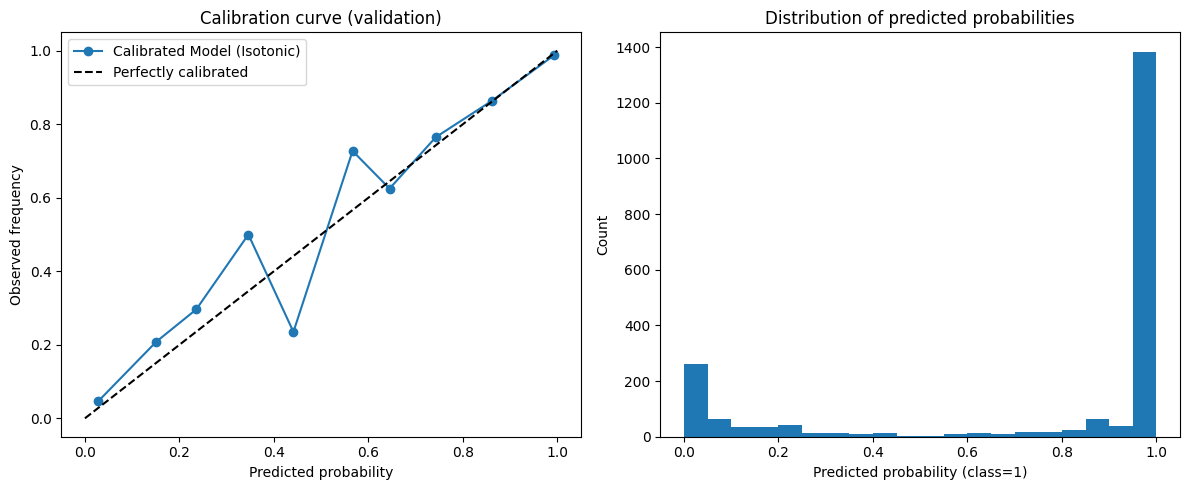

Brier score (1 is worst performance and 0 is perfect): 0.0434310984987691
Baseline Score (Performance of a random guesser using data distribution): 0.1778
Skill Score (How much better our model is over the random guesser): 0.76


In [7]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

import numpy as np

y_val_proba = model.predict_proba(X_val)[:, 1]

prob_true, prob_pred = calibration_curve(y_val, y_val_proba, n_bins=10, strategy='uniform')

fig, (ax_cal, ax_hist) = plt.subplots(1, 2, figsize=(12, 5))

# Brier score for

brier_score = brier_score_loss(y_val, y_val_proba)

dummy_probs = [y_train.mean()] * len(y_val)
baseline_score = brier_score_loss(y_val, dummy_probs)

# Bin Count before plotting

n_bins = 10
edges = np.linspace(0, 1, n_bins + 1)

bin_labels = pd.IntervalIndex.from_breaks(edges)
bin_assignment = pd.cut(y_val_proba, bins=edges, include_lowest=True)

bin_counts = bin_assignment.value_counts().sort_index()
print('Bins Count: \n', bin_counts)

# Calibration curve
ax_cal.plot(prob_pred, prob_true, marker='o', label='Calibrated Model (Isotonic)')
ax_cal.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
ax_cal.set_xlabel('Predicted probability')
ax_cal.set_ylabel('Observed frequency')
ax_cal.set_title('Calibration curve (validation)')
ax_cal.legend()

# Probability histogram
ax_hist.hist(y_val_proba, bins=20, color='#1f77b4')
ax_hist.set_xlabel('Predicted probability (class=1)')
ax_hist.set_ylabel('Count')
ax_hist.set_title('Distribution of predicted probabilities')

plt.tight_layout()
plt.show()

print('Brier score (1 is worst performance and 0 is perfect):', brier_score)
print(
    f'Baseline Score (Performance of a random guesser using data distribution): {baseline_score:.4f}'
)
print(
    f'Skill Score (How much better our model is over the random guesser): {1 - (brier_score / baseline_score):.2f}'
)

In the callibration curve plot we can see that our model is well callibrated for probabilities which are very frequent. The bin count shows that (0-0.1] and (0.9-1.0], the perfectly callibrated predictions represent 70% of the datapoints. 

The callibration curve looks off in the middle, for 0.3-0.6 bins, but this should not affect real performance because these bins represent <3% of the data, so 97% of the predictions mostly fall into callibrated bins. 

This should be enough to conclude that our model is well callibrated. 

### **PR-AUC** for the Negative Class **after the model has been calibrated**

=== NEGATIVE PR-AUC ===
0.933678270405127


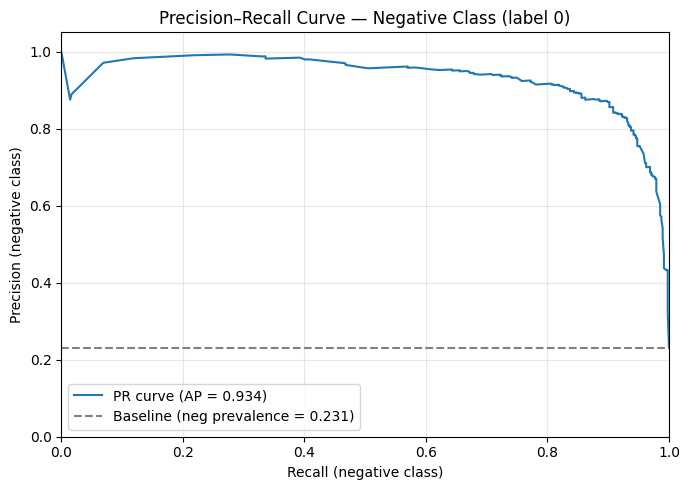

In [8]:
p_neg = model.predict_proba(X_val)[:, 0]
y_neg = (y_val == 0).astype(int)

precision_neg, recall_neg, pr_thresholds = precision_recall_curve(y_neg, p_neg)
pr_auc_neg = average_precision_score(y_neg, p_neg)

print('=== NEGATIVE PR-AUC ===')
print(average_precision_score(y_neg, p_neg))

plt.figure(figsize=(7, 5))
plt.plot(recall_neg, precision_neg, label=f'PR curve (AP = {pr_auc_neg:.3f})')
# Baseline = fraction of negatives in the data
neg_prevalence = y_neg.mean()
plt.hlines(
    neg_prevalence,
    0,
    1,
    colors='gray',
    linestyles='dashed',
    label=f'Baseline (neg prevalence = {neg_prevalence:.3f})',
)
plt.xlabel('Recall (negative class)')
plt.ylabel('Precision (negative class)')
plt.title('Precision–Recall Curve — Negative Class (label 0)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The curve has a dip at the very beginning. This means that our model predicted with a very high confidence a review which was not negative. There are some possibilities about why this could have happened: The data was incorrectly labelled: the reviews are labelled using the rating as a ground truth: E.g: 4-5 stars are considered a postiive review, so if a person rated the gym with 5 stars but wrote the comment: "este gimnasio es una mierda, siempre huele mal", the model will correctly predict the negative sentiment, but the ground truth label will classify the prediction as incorrect. Another possibility is that ambiguous reviews which contain positive and negative words may fool the model to predict the incorrect sentiment. To check what is the problem, we filter the reviews which our model is very confident on being negative but also have a positive label (1) assigned. 

In [55]:
# Assuming X_val is a Series/DataFrame aligned with y_val
neg_probs = model.predict_proba(X_val)[:, 0]  # prob of class=0 (negative)

analysis_df = pd.DataFrame(
    {
        'id': df_val['id'],
        'comment': X_val[:],
        'true_label': y_val,
        'prob_negative': neg_probs,
    }
)

top_neg = analysis_df.sort_values('prob_negative', ascending=False)
debug = top_neg.loc[(top_neg['true_label'] == 1) & (top_neg['prob_negative'] >= 0.5)]
print(debug.iloc[:10, :])
debug.to_csv('debug.csv', index=False)

         id                                            comment  true_label  \
638    1048                                         no taaaaan           1   
1431   8787  por favor arregluen ya la barrera de entrada e...           1   
1219  12255                              no e estado nunca hay           1   
1414   9698  todo genial menos que en las clases no se resp...           1   
594    8488  es hermosoooo de todos los que visitado me par...           1   
335    1953  hay mucha gente en el gimnasio que no utiliza ...           1   
1557  11226  un gimnasio muy completo el personal es simpat...           1   
1273   8734  cambio mi reseña por que ya han subido la temp...           1   
701   11790  muy buen gimnasio con continuas mejoras la gen...           1   
1204   8755  pongo la reseña no por la calidad de las insta...           1   

      prob_negative  
638        1.000000  
1431       0.988228  
1219       0.979592  
1414       0.972093  
594        0.968430  
335      

It is a mixed of a: reviews which talk about negative aspects of the gym but give it 4-5 stars and b: reviews which mention positive and negative aspects of the gym, but overall give a good rating. These type of reviews are not the ones which require instant attention from a business perspective, so detecting them is a secondary matter.

The PR-AUC plot shows that the model has a high area under the curve. This means that the model is pretty good at ranking the reviews sentiment. ~90% of recall is ideal for our task, so we adjust the threshold a tiny bit to reach 90% of recall for the negative class. 

In [9]:
p_neg = model.predict_proba(X_val)[:, 0]
y_neg = (y_val == 0).astype(int)

precision_neg, recall_neg, pr_thresholds = precision_recall_curve(y_neg, p_neg)
pr_auc_neg = average_precision_score(y_neg, p_neg)


precision = precision_neg[1:]
recall = recall_neg[1:]
target_recall = 0.90

valid_idxs = np.where(recall >= target_recall)[0]

if len(valid_idxs) == 0:
    print('No threshold achieves the desired recall.')
else:
    # Choose the highest threshold that still delivers recall >= target
    best_idx = valid_idxs[-1]
    best_thresh = pr_thresholds[best_idx]

    print(f'Chosen threshold (recall >= {target_recall}): {best_thresh:.5f}')
    print(f'Recall at threshold: {recall[best_idx]:.3f}')
    print(f'Precision at threshold: {precision[best_idx]:.3f}')

Chosen threshold (recall >= 0.9): 0.43899
Recall at threshold: 0.902
Precision at threshold: 0.869


As seen above, the 0.44 threshold provides us with our desired 90% recall score. This means, that instead of using the default 0.5 threshold to classify a review as negative, we will consider it negative when the probability >=0.44 or >0.43 . Now, it's important to see if this threshold doesn't downgrade the rest of the metrics.

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Probabilities for the negative class (class 0)
y_proba_neg = model.predict_proba(X_val)[:, 0]

# Apply the new threshold
y_pred_custom = np.where(y_proba_neg >= best_thresh, 0, 1)

neg_precision = precision_score(y_val, y_pred_custom, pos_label=0)
neg_recall = recall_score(y_val, y_pred_custom, pos_label=0)
neg_f1 = f1_score(y_val, y_pred_custom, pos_label=0)

pos_precision = precision_score(y_val, y_pred_custom, pos_label=1)
pos_recall = recall_score(y_val, y_pred_custom, pos_label=1)
pos_f1 = f1_score(y_val, y_pred_custom, pos_label=1)

print('=== NEGATIVE CLASS METRICS (label 0) ===')
print(f'Precision: {neg_precision:.3f}')
print(f'Recall:    {neg_recall:.3f}')
print(f'F1-score:  {neg_f1:.3f}')

print('\n=== POSITIVE CLASS METRICS (label 1) ===')
print(f'Precision: {pos_precision:.3f}')
print(f'Recall:    {pos_recall:.3f}')
print(f'F1-score:  {pos_f1:.3f}')

=== NEGATIVE CLASS METRICS (label 0) ===
Precision: 0.867
Recall:    0.902
F1-score:  0.884

=== POSITIVE CLASS METRICS (label 1) ===
Precision: 0.970
Recall:    0.959
F1-score:  0.964


At first glance, they look decent. Let's test our final model on the test set.

In [ ]:
# Predict on val set
test_path = Path('data/processed/splits/test/test.csv')

df_test = pd.read_csv(test_path)

X_test = df_test['comment'].astype(str)
y_test = df_test['sentiment'].map({'negative': 0, 'positive': 1}).astype(int)

p_neg = model.predict_proba(X_test)[:, 0]
y_neg = (y_test == 0).astype(int)

# Probabilities for the negative class (class 0)
y_proba_neg = model.predict_proba(X_test)[:, 0]

# Apply the new threshold
y_pred_custom = np.where(y_proba_neg >= best_thresh, 0, 1)

print('Test Set - classification report (test): \n')
print(classification_report(y_test, y_pred_custom))

print('Negative PR-AUC:', average_precision_score(y_neg, p_neg))

print(
    model.predict_proba(
        pd.Series(['Este gimnasio es una porquería, el monitor es una mierda de persona!'])
    )[:, 0]
)

Test Set - classification report (test): 

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       479
           1       0.97      0.95      0.96      1593

    accuracy                           0.95      2072
   macro avg       0.92      0.93      0.92      2072
weighted avg       0.95      0.95      0.95      2072

Negative PR-AUC: 0.937278935870522
[0.42758871]


With this, we can conclude that our model has also got a good score on the test set. Our final metrics are:

- F1 score (negative class): **0.89**
- Recall (negative class): **0.91**
- Macro-F1: **0.92**
- PR-AUC: **0.94**


### Create a model version folder + save our artifact + metadata

In [28]:
from pathlib import Path
import json
import hashlib
import subprocess
import platform
import joblib
import sklearn
import numpy as np
import pandas as pd
from datetime import datetime, UTC


def sha256_file(path: str) -> str:
    h = hashlib.sha256()
    with Path.open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b''):
            h.update(chunk)
    return h.hexdigest()


def git_info() -> dict:
    info = {
        'commit': 'unknown',
        'dirty': None,
        'branch': None,
    }

    try:
        info['commit'] = subprocess.check_output(
            ['git', 'rev-parse', 'HEAD'],
            stderr=subprocess.DEVNULL,
            text=True,
        ).strip()

        info['branch'] = subprocess.check_output(
            ['git', 'rev-parse', '--abbrev-ref', 'HEAD'],
            stderr=subprocess.DEVNULL,
            text=True,
        ).strip()

        status = subprocess.check_output(
            ['git', 'status', '--porcelain'],
            stderr=subprocess.DEVNULL,
            text=True,
        )
        info['dirty'] = bool(status.strip())

    except Exception:
        pass

    return info


def save_model_artifact(
    pipeline,
    model_name: str,
    out_root: str,
    metrics: dict,
    threshold_used: float | None,
    label_mapping: dict,
    training_data_paths: list[str] | None = None,
    extra_metadata: dict | None = None,
):
    # version id: YYYY-MM-DD_NNN (simple, readable)
    today = datetime.now(UTC).strftime('%Y-%m-%d')
    base_dir = Path(out_root) / model_name
    base_dir.mkdir(parents=True, exist_ok=True)

    # find next run index
    existing = sorted([p.name for p in base_dir.glob(f'{today}_*') if p.is_dir()])
    next_idx = (int(existing[-1].split('_')[-1]) + 1) if existing else 1
    version = f'{today}_{next_idx:03d}'
    out_dir = base_dir / version
    out_dir.mkdir(parents=True, exist_ok=False)

    # 1) save model pipeline
    model_path = out_dir / 'model.joblib'
    joblib.dump(pipeline, model_path, compress=3)

    # 2) compute dataset fingerprints (optional but recommended)
    data_hashes = {}
    if training_data_paths:
        for p in training_data_paths:
            try:
                data_hashes[p] = sha256_file(p)
            except FileNotFoundError:
                data_hashes[p] = 'missing'

    # 3) metadata (the “contract-adjacent” core facts)
    meta = {
        'model_name': model_name,
        'model_version': version,
        'created_at_utc': datetime.now(UTC).isoformat(),
        'git_commit': git_info(),
        'python_version': platform.python_version(),
        'sklearn_version': sklearn.__version__,
        'numpy_version': np.__version__,
        'artifact': {
            'format': 'joblib',
            'path': str(model_path),
        },
        'label_mapping': label_mapping,  # e.g., {"negative": 0, "positive": 1}
        'threshold_used': threshold_used,  # your chosen decision threshold (if any)
        'score_semantics': 'predict_proba for class=positive (index per label_mapping)',  # set correctly for your case
        'training_data': {
            'paths': training_data_paths or [],
            'sha256': data_hashes,
        },
    }
    if extra_metadata:
        meta.update(extra_metadata)

    (out_dir / 'metadata.json').write_text(json.dumps(meta, indent=2), encoding='utf-8')
    (out_dir / 'metrics.json').write_text(json.dumps(metrics, indent=2), encoding='utf-8')

    # 4) lightweight runtime deps snapshot
    try:
        # minimal, not perfect; good enough for your repo
        (out_dir / 'requirements.txt').write_text(
            '\n'.join(
                [
                    f'scikit-learn=={sklearn.__version__}',
                    f'numpy=={np.__version__}',
                    'joblib',
                ]
            )
            + '\n',
            encoding='utf-8',
        )
    except Exception:
        pass

    # 5) example request (useful later for API tests)
    (out_dir / 'example_request.json').write_text(
        json.dumps({'review_text': 'Muy buen gimnasio! Los monitores son muy guapos!'}, indent=2),
        encoding='utf-8',
    )

    return str(out_dir)


# ---- usage: fill these from your notebook ----
MODEL_NAME = 'sentiment_logreg'
OUT_ROOT = 'artifacts/models'

# Final metrics
final_metrics = {
    'macro_f1': 0.92,
    'f1_negative': 0.89,
    'pr_auc': 0.94,
    'recall_negative': 0.91,
}

# If you tuned a decision threshold, include it
threshold_used = 0.44  # Tuned to achieve 0.90 recall

label_mapping = {'negative': 0, 'positive': 1}  # set to your actual mapping

# Optional: point to the processed train/val/test csv/parquet you used
training_data_paths = [
    'data/frozen/sentiment_logreg/2025.12.15_01/test/test.csv',
    'data/frozen/sentiment_logreg/2025.12.15_01/val/val.csv',
    'data/frozen/sentiment_logreg/2025.12.15_01/train/train.csv',
]

artifact_dir = save_model_artifact(
    pipeline=model,
    model_name=MODEL_NAME,
    out_root=OUT_ROOT,
    metrics=final_metrics,
    threshold_used=threshold_used,
    label_mapping=label_mapping,
    training_data_paths=training_data_paths,
)

print('Saved model artifact to:', artifact_dir)

Saved model artifact to: artifacts\models\sentiment_logreg\2025-12-15_002
